### 真实世界与风险中性世界下的衍生品定价
#### 郑宇浩 41621101
#### yuba316@hotmail.com
#### 该notebook文件生成论文中所有需要的图片与表格数据，需要导入的数据存储于名为“代码”的文件夹下

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.stats import norm

#### 1. 生成布朗运动及其鞅过程证明

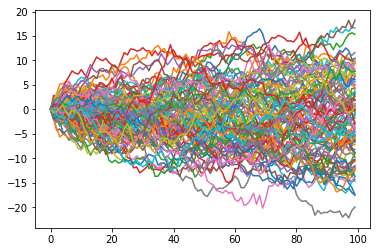

In [2]:
np.random.seed(20190314)
W=np.zeros(shape=(100,100))
for i in range(1,100):
    W[:,i]=np.random.normal(0,1,100)
for i in range(1,100):
    W[:,i]=W[:,i]+W[:,i-1]
step=range(100)
for i in range(100):
    plt.plot(step,W[i,:])

In [3]:
# 鞅过程

print(str(np.mean(W[:,25:]))+" ≈ "+str(np.mean(W[:,75:])))

-1.3910709335179783 ≈ -1.5436252575139435


#### 2. 生成伊藤过程及其鞅过程与二次偏差证明

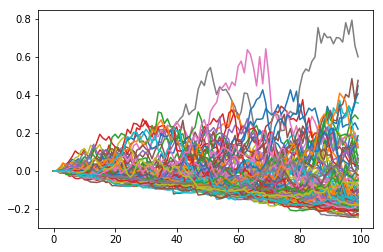

In [4]:
delta=np.zeros(shape=(100,100))
delta=W
Ito=np.zeros(shape=(100,100))
for i in range(1,100):
    Ito[:,i]=Ito[:,i-1]+1/252*delta[:,i-1]*(W[:,i]-W[:,i-1])
for i in range(100):
    plt.plot(step,Ito[i,:])

In [5]:
# 鞅过程

print(str(np.mean(Ito[:,25:]))+" ≈ "+str(np.mean(Ito[:,75:])))

-0.030984866422759178 ≈ -0.052359111025275754


In [6]:
# 二次偏差

P=np.zeros(100)
Q=np.zeros(100)
for h in range(100):
    P[h]=sum(np.square(1/252*delta[h,:]))
    for i in range(1,100):
        Q[h]=Q[h]+np.square((Ito[h,i]-Ito[h,i-1]))
print(str(np.mean(P))+" ≈ "+str(np.mean(Q)))

0.05867583321949889 ≈ 0.05723395316588685


#### 3. 生成真实世界下的股票轨道

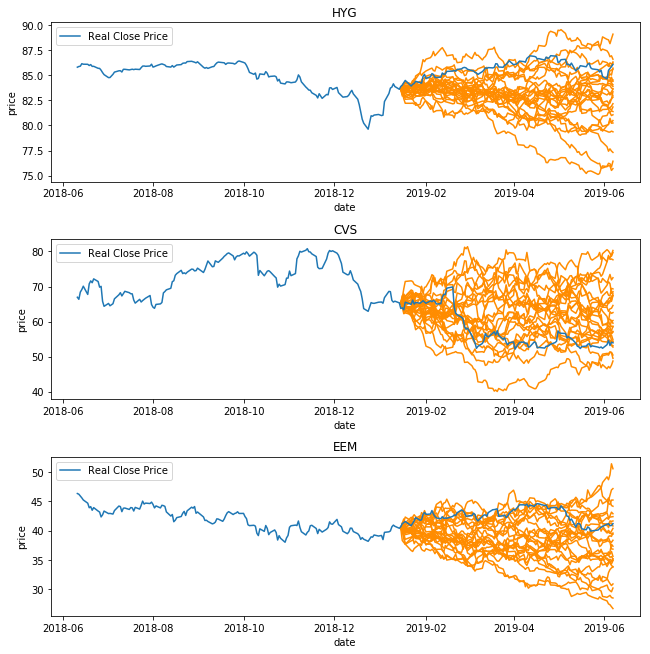

In [7]:
excel_name=r"E:\大三下\金融随机\代码\Stock.xlsx"
wb=pd.ExcelFile(excel_name)
stock_name=wb.sheet_names
m=len(stock_name)
stock={}
for i in range(m):
    df=wb.parse(stock_name[i],index_col=0)
    stock[stock_name[i]]=df
real_ST={}
error={} # 记录残差平方和均值
MSE={} # 记录均方误差
plt.figure(figsize=(9,9))
for i in range(m):
    date=stock[stock_name[i]].index
    stock_close=stock[stock_name[i]]["Close"]
    sum_1=0
    sum_2=0
    for j in range(150-1):
        log=math.log(stock_close[j+1]/stock_close[j])
        sum_1=sum_1+np.square(log)
        sum_2=sum_2+log
    sigma=math.sqrt(sum_1/150)
    alpha=sum_2/150
    St=stock_close[150-1]
#——————————————以上完成历史股价收益率均值与标准差计算——————————————
#——————————————以下生成布朗运动与真实世界下的股价轨道——————————————
    W=np.zeros(shape=(25,100))
    np.random.seed(91020609+i)
    for j in range(1,100):
        W[:,j]=np.random.normal(0,1,25)
    for j in range(1,100):
        W[:,j]=W[:,j]+W[:,j-1]
    time=np.arange(1,101,1)
    ST=np.zeros(shape=(25,100))
    Err=np.zeros(shape=(25,100))
    for j in range(25):
        ST[j,:]=St*np.exp(sigma*W[j,:]+(alpha-0.5*np.square(sigma))*time)
        Err[j,:]=np.square(ST[j,:]-stock_close[150:])
    Err_t=np.zeros(100)
    Mean=np.zeros(100)
    for j in range(100):
        Err_t[j]=np.mean(Err[:,j])
        Mean[j]=np.mean(ST[:,j])
    real_ST[stock_name[i]]=ST
    error[stock_name[i]]=Err_t
    MSE[stock_name[i]]=np.mean(np.square(Mean-stock_close[150:]))
#——————————————以下作图多条模拟股价轨道与真实股价对比——————————————
    plt.subplot(3,1,i+1)
    for j in range(25):
        plt.plot(date[150:],ST[j,:],color="#FF8C00")
    plt.plot(date,stock_close,label="Real Close Price")
    plt.title(stock_name[i])
    plt.legend(bbox_to_anchor=(0,1),loc=2)
    plt.tight_layout()
    plt.xlabel("date")
    plt.ylabel("price")

In [8]:
for i in stock_name:
    print(str(i)+"第25步、50步、75步和100步的残差平方和均值为: \n"
          +str(error[i][24])+" "+str(error[i][49])+" "
          +str(error[i][74])+" "+str(error[i][99])+"\n")
    print(str(i)+"的均方误差为: \n"+str(MSE[i])+"\n")

HYG第25步、50步、75步和100步的残差平方和均值为: 
4.899158806565393 12.165161144001111 19.829316747035374 21.392435407684683

HYG的均方误差为: 
7.42090167906607

CVS第25步、50步、75步和100步的残差平方和均值为: 
44.739744845915055 153.4214807675235 78.19881036511974 146.69774204819316

CVS的均方误差为: 
47.56742451154747

EEM第25步、50步、75步和100步的残差平方和均值为: 
18.270631148133212 24.243903462307916 50.40494290072789 43.7840260476018

EEM的均方误差为: 
16.017982633756198



#### 4. 生成带漂移项的布朗运动

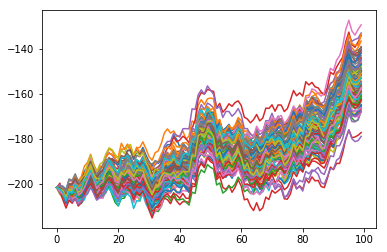

In [9]:
Bond=pd.read_excel(r"E:\大三下\金融随机\代码\Bond.xlsx",index_col=0)
rate=Bond["Close"]
theta=np.zeros(100)
theta=(alpha-rate)/sigma
driff_W=np.zeros(shape=(100,100))
np.random.seed(20190610)
for j in range(1,100):
    driff_W[:,j]=np.random.normal(0,1,100)
for j in range(1,100):
    driff_W[:,j]=driff_W[:,j]+driff_W[:,j-1]
for j in range(100):
    driff_W[:,j]=driff_W[:,j]+theta[j]
for j in range(100):
    plt.plot(driff_W[j,:])

#### 5. 生成风险中性世界下的股票轨道

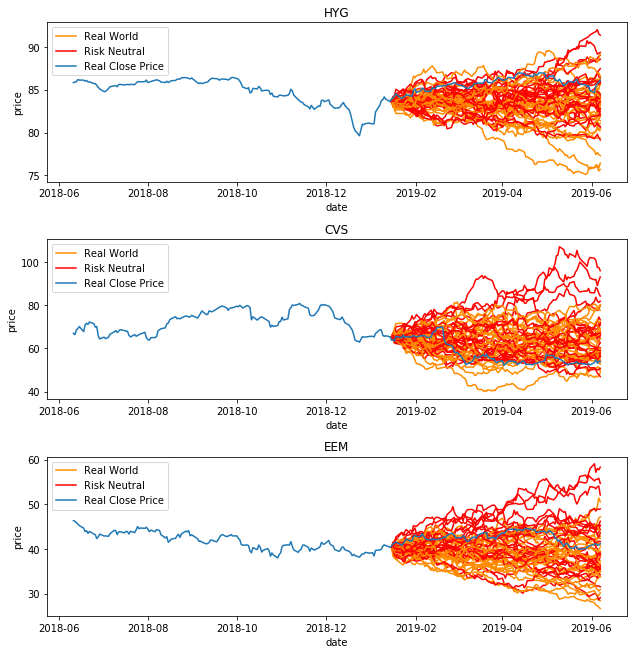

In [10]:
RN_ST={}
RN_error={}
RN_MSE={}
plt.figure(figsize=(9,9))
for i in range(m):
    date=stock[stock_name[i]].index
    stock_close=stock[stock_name[i]]["Close"]
    sum_1=0
    sum_2=0
    for j in range(150-1):
        log=math.log(stock_close[j+1]/stock_close[j])
        sum_1=sum_1+np.square(log)
        sum_2=sum_2+log
    sigma=math.sqrt(sum_1/150)
    alpha=sum_2/150
    St=stock_close[150-1]
#——————————————以上完成历史股价收益率均值与标准差计算——————————————
#——————————————以下生成带漂移项的布朗运动————————————————————
    theta=np.zeros(100)
    theta=(alpha-rate)/sigma
    driff_W=np.zeros(shape=(25,100))
    np.random.seed(91020609+m+i)
    for j in range(1,100):
        driff_W[:,j]=np.random.normal(0,1,25)
    for j in range(1,100):
        driff_W[:,j]=driff_W[:,j]+driff_W[:,j-1]
    for j in range(100):
        driff_W[:,j]=driff_W[:,j]+theta[j]
    time=np.arange(1,101,1)
    ST=np.zeros(shape=(25,100))
    Err=np.zeros(shape=(25,100))
    for j in range(25):
        ST[j,:]=St*np.exp(sigma*driff_W[j,:]+(rate-0.5*np.square(sigma)))
        Err[j,:]=np.square(ST[j,:]-stock_close[150:])
    Err_t=np.zeros(100)
    Mean=np.zeros(100)
    for j in range(100):
        Err_t[j]=np.mean(Err[:,j])
        Mean[j]=np.mean(ST[:,j])
    RN_ST[stock_name[i]]=ST
    RN_error[stock_name[i]]=Err_t
    RN_MSE[stock_name[i]]=np.mean(np.square(Mean-stock_close[150:]))
#——————————————以下作图多条模拟股价轨道与真实股价对比——————————————
    plt.subplot(3,1,i+1)
    plt.plot(date[150:],real_ST[stock_name[i]][0,:],color="#FF8C00",label="Real World")
    plt.plot(date[150:],ST[0,:],color="r",label="Risk Neutral")
    for j in range(1,25,1):
        plt.plot(date[150:],real_ST[stock_name[i]][j,:],color="#FF8C00")
        plt.plot(date[150:],ST[j,:],color="r")
    plt.plot(date,stock_close,label="Real Close Price")
    plt.title(stock_name[i])
    plt.legend(bbox_to_anchor=(0,1),loc=2)
    plt.tight_layout()
    plt.xlabel("date")
    plt.ylabel("price")

In [11]:
for i in stock_name:
    print(str(i)+"第25步、50步、75步和100步的残差平方和均值为: \n"
          +str(RN_error[i][24])+" "+str(RN_error[i][49])+" "
          +str(RN_error[i][74])+" "+str(RN_error[i][99])+"\n")
    print(str(i)+"的均方误差为: \n"+str(RN_MSE[i])+"\n")

HYG第25步、50步、75步和100步的残差平方和均值为: 
5.039219880827132 9.110885423498114 9.32517646208057 11.031695854179883

HYG的均方误差为: 
3.641529068702834

CVS第25步、50步、75步和100步的残差平方和均值为: 
40.865103529196574 208.7736769384511 221.39006095831803 324.04337860553585

CVS的均方误差为: 
99.52983612437666

EEM第25步、50步、75步和100步的残差平方和均值为: 
8.296090794407366 19.83530959140417 42.951564738149955 49.59237521818786

EEM的均方误差为: 
3.0997132701837598



#### 6. 期权价格模拟

In [12]:
tao=[5,10,50]
K={}
K[stock_name[0]]=np.array([[84.5,85,85.5],[60,65,76],[75,80,82]])
K[stock_name[1]]=np.array([[48,49,50],[35,40,42.5],[30,35,37.5]])
K[stock_name[2]]=np.array([[33.5,34,34.5],[20,21,22],[26,34,35]])
Real_Call={} # 记录真实世界下的期权价格
Risk_Neutral_Call={} # 记录风险中性世界下的期权价格
Alpha={}
Sigma={}
for i in range(m):
    date=stock[stock_name[i]].index
    stock_close=stock[stock_name[i]]["Close"]
    sum_1=0
    sum_2=0
    n=len(date)
    for j in range(n-1):
        log=math.log(stock_close[j+1]/stock_close[j])
        sum_1=sum_1+np.square(log)
        sum_2=sum_2+log
    sigma=math.sqrt(sum_1/n)
    alpha=sum_2/n
    Alpha[stock_name[i]]=alpha
    Sigma[stock_name[i]]=sigma
    St=stock_close[n-1]
#——————————————以上完成历史股价收益率均值与标准差计算——————————————
#——————————————以下生成布朗运动与两种世界下的期权价格——————————————
    real_call=np.zeros(shape=(3,3))
    risk_neutral_call=np.zeros(shape=(3,3))
    theta=(alpha-rate[-1])/sigma
    for j in range(3):
        W=np.zeros(shape=(1000,tao[j]))
        driff_W=np.zeros(shape=(1000,tao[j]))
        np.random.seed(91020609+m+m+m*j+i)
        for k in range(1,tao[j]):
            W[:,k]=np.random.normal(0,1,1000)
        for k in range(1,tao[j]):
            W[:,k]=W[:,k]+W[:,k-1]
        for k in range(tao[j]):
            driff_W[:,k]=driff_W[:,k]+theta
        time=np.arange(1,tao[j]+1,1)
        ST=np.zeros(shape=(1000,tao[j]))
        RN_ST=np.zeros(shape=(1000,tao[j]))
        for k in range(1000):
            ST[k,:]=St*np.exp(sigma*W[k,:]+(alpha-0.5*np.square(sigma))*time)
            RN_ST[k,:]=St*np.exp(sigma*driff_W[j,:]+(rate[-1]-0.5*np.square(sigma)))
        Call=np.zeros(1000)
        RN_Call=np.zeros(1000)
        for k in range(1000):
            for l in range(3):
                d1=(np.log(ST[k,tao[j]-1]/K[stock_name[i]][j,l])+(rate[-1]+1/2*np.square(sigma))*tao[j]/252)/(sigma*np.sqrt(tao[j]/252))
                RN_d1=(np.log(RN_ST[k,tao[j]-1]/K[stock_name[i]][j,l])+(rate[-1]+1/2*np.square(sigma))*tao[j]/252)/(sigma*np.sqrt(tao[j]/252))
                d2=d1-(sigma*np.sqrt(tao[j]/252))
                RN_d2=RN_d1-(sigma*np.sqrt(tao[j]/252))
                Nd1=norm.cdf(d1)
                Nd2=norm.cdf(d2)
                RN_Nd1=norm.cdf(RN_d1)
                RN_Nd2=norm.cdf(RN_d2)
                Call[k]=ST[k,tao[j]-1]*Nd1-K[stock_name[i]][j,l]*np.exp(-rate[-1]*tao[j]/252)*Nd2
                RN_Call[k]=RN_ST[k,tao[j]-1]*RN_Nd1-K[stock_name[i]][j,l]*np.exp(-rate[-1]*tao[j]/252)*RN_Nd2
                real_call[j,l]=np.mean(Call)
                risk_neutral_call[j,l]=np.mean(RN_Call)
    Real_Call[stock_name[i]]=real_call
    Risk_Neutral_Call[stock_name[i]]=risk_neutral_call

In [13]:
Real_Call # 真实世界下

{'HYG': array([[ 4.05963866,  4.05915891,  4.05867916],
        [16.12928481, 16.12468166, 16.11455475],
        [31.99515232, 31.99184563, 31.99052296]]),
 'CVS': array([[ 5.6530062 ,  5.65204671,  5.65108721],
        [14.42319364, 14.41859049, 14.41628892],
        [27.10842296, 27.10511628, 27.10346293]]),
 'EEM': array([[ 7.99620271,  7.99572296,  7.99524322],
        [20.7555792 , 20.75465857, 20.75373794],
        [17.04818177, 17.04289108, 17.04222974]])}

In [14]:
Risk_Neutral_Call # 风险中性世界下

{'HYG': array([[ 4.06486925,  4.0643895 ,  4.06390976],
        [16.14759227, 16.14298913, 16.13286221],
        [31.87566076, 31.87235408, 31.8710314 ]]),
 'CVS': array([[ 5.8914826 ,  5.89052311,  5.88956361],
        [14.74444673, 14.73984359, 14.73754201],
        [29.06909477, 29.06578809, 29.06413475]]),
 'EEM': array([[ 8.05594243,  8.05546268,  8.05498293],
        [20.90553492, 20.90461429, 20.90369366],
        [18.0166909 , 18.01140021, 18.01073887]])}